In [1]:
# Install KISS-ICP and Plotting tools
import os

import numpy as np
from kiss_icp.datasets import dataset_factory
from kiss_icp.pipeline import OdometryPipeline
import matplotlib.pyplot as plt
import tqdm
from model import PointTransformerV3
import torch
from collections import OrderedDict

/home/vladislav/miniconda3/envs/pointcept/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vladislav/miniconda3/envs/pointcept/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
segmodel = PointTransformerV3(
    in_channels=4,
    order=["z", "z-trans", "hilbert", "hilbert-trans"],
    stride=(2, 2, 2, 2),
    enc_depths=(2, 2, 2, 6, 2),
    enc_channels=(32, 64, 128, 256, 512),
    enc_num_head=(2, 4, 8, 16, 32),
    enc_patch_size=(128, 128, 128, 128, 128),
    dec_depths=(2, 2, 2, 2),
    dec_channels=(64, 64, 128, 256),
    dec_num_head=(4, 4, 8, 16),
    dec_patch_size=(128, 128, 128, 128),
    mlp_ratio=4,
    qkv_bias=True,
    qk_scale=None,
    attn_drop=0.0,
    proj_drop=0.0,
    drop_path=0.3,
    shuffle_orders=True,
    pre_norm=True,
    enable_rpe=False,
    enable_flash=False,
    upcast_attention=False,
    upcast_softmax=False,
    cls_mode=False,
    pdnorm_bn=False,
    pdnorm_ln=False,
    pdnorm_decouple=True,
    pdnorm_adaptive=False,
    pdnorm_affine=True,
    pdnorm_conditions=("nuScenes", "SemanticKITTI", "Waymo"),
).cuda()
seg_head = torch.nn.Linear(64, 19).cuda()

checkpoint = torch.load(
    "best_model.pth", map_location=lambda storage, loc: storage.cuda()
)

weight_backbone = OrderedDict()
weight_seg_head = OrderedDict()

for key, value in checkpoint.items():
    if "backbone" in key:
        weight_backbone[key.replace("module.backbone.", "")] = value
    elif "seg_head" in key:
        weight_seg_head[key.replace("module.seg_head.", "")] = value

load_state_info1 = segmodel.load_state_dict(weight_backbone, strict=True)
load_state_info2 = seg_head.load_state_dict(weight_seg_head, strict=True)
assert load_state_info1 and load_state_info2

In [3]:
data_root = ".."
sequence_root = os.path.join(data_root, "Huawei/dataset/sequences/02")
save_root = os.path.join(data_root, "Huawei/dataset/sequences/02")
lidar_root = os.path.join(sequence_root, "velodyne")
labels_root = os.path.join(sequence_root, "labels")
poses_path = os.path.join(sequence_root, "poses.npy")
pred_root = os.path.join(save_root, "predictions_norm")

# pipeline = OdometryPipeline(
#     dataset=dataset_factory(
#         dataloader="generic",
#         data_dir=lidar_root,
#     )
# )

# seq_res = pipeline.run()
# seq_res.print()
# poses = np.asarray(pipeline.poses).reshape(len(pipeline.poses), 4, 4)
poses = np.load(poses_path)

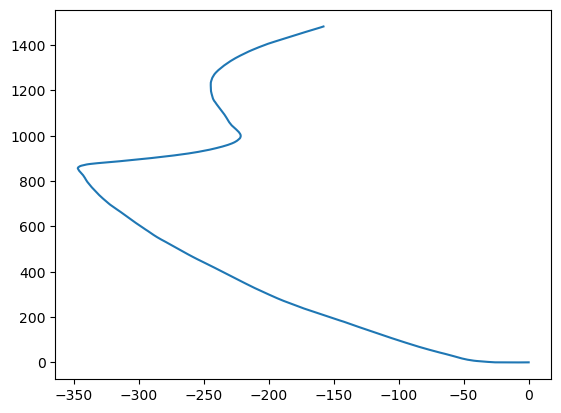

In [4]:
plt.plot(poses[:,0,3], poses[:,1,3])

In [5]:
pcd_files = sorted(os.listdir(lidar_root))
len(pcd_files)

1197

In [6]:
learning_map_inv = {
            "ignore_index": -1,  # "unlabeled"
            0: 10,  # "car"
            1: 11,  # "bicycle"
            2: 15,  # "motorcycle"
            3: 18,  # "truck"
            4: 20,  # "other-vehicle"
            5: 30,  # "person"
            6: 31,  # "bicyclist"
            7: 32,  # "motorcyclist"
            8: 40,  # "road"
            9: 44,  # "parking"
            10: 48,  # "sidewalk"
            11: 49,  # "other-ground"
            12: 50,  # "building"
            13: 51,  # "fence"
            14: 70,  # "vegetation"
            15: 71,  # "trunk"
            16: 72,  # "terrain"
            17: 80,  # "pole"
            18: 81,  # "traffic-sign"
        }

In [7]:
def fnv_hash_vec(arr):
    """
    FNV64-1A hash for a 2D array.
    """
    assert arr.ndim == 2
    arr = arr.copy()
    arr = arr.astype(np.uint64, copy=False)
    hashed_arr = np.uint64(14695981039346656037) * np.ones(arr.shape[0], dtype=np.uint64)
    for j in range(arr.shape[1]):
        hashed_arr *= np.uint64(1099511628211)
        hashed_arr = np.bitwise_xor(hashed_arr, arr[:, j])
    return hashed_arr

In [8]:
def grid_sample(data, grid_size):
    scaled_coord = data[:,:3] / np.array(grid_size)
    grid_coord = np.floor(scaled_coord).astype(int)
    min_coord = grid_coord.min(0)
    grid_coord -= min_coord
    scaled_coord -= min_coord
    min_coord = min_coord * np.array(grid_size)
    key = fnv_hash_vec(grid_coord)
    idx_sort = np.argsort(key)
    key_sort = key[idx_sort]
    _, inverse, count = np.unique(key_sort, return_inverse=True, return_counts=True)
    idx_select = (
        np.cumsum(np.insert(count, 0, 0)[0:-1])
        + np.random.randint(0, count.max(), count.size) % count
    )
    idx_unique = idx_sort[idx_select]
    return data[idx_unique], grid_coord[idx_unique], min_coord.reshape([1, 3]), idx_sort, count, inverse, idx_select

In [ ]:
pcd_heap = []
pcd_lens = []
pcd_ind = []
heap_size = 1
procceed_full = True
with torch.no_grad():
    for pcd_file_id in tqdm.tqdm(range(len(pcd_files))):
        pts = np.fromfile(
            os.path.join(lidar_root, pcd_files[pcd_file_id]), dtype=np.float32
        ).reshape((-1, 4))
        # pts[:,3] /= (254*140)

        pts_hom = np.hstack([pts[:, :3], np.ones((pts.shape[0], 1), dtype=pts.dtype)])
        transformed = (
            poses[pcd_file_id]
            @ pts_hom.T
        ).T
        pts[:, :3] = transformed[:, :3]
        pcd_heap.append(pts.copy())
        pcd_lens.append(pts.shape[0])
        pcd_ind.append(pcd_file_id)
        if len(pcd_heap) > heap_size:
            pcd_heap.pop(0)
            pcd_lens.pop(0)
            pcd_ind.pop(0)
        heaped_pts = np.vstack(pcd_heap)

        

        if procceed_full:
            feat = torch.as_tensor(heaped_pts).cuda()
            batch = torch.zeros(feat.shape[0],dtype=int).cuda()
            data = {
                "feat": feat,
                "coord": feat[:,:3],
                "grid_size": 0.05,
                "batch": batch,
            }
            probs = torch.softmax(seg_head(segmodel(data)["feat"]), dim=1)
            labels = torch.argmax(probs, dim=1).cpu().numpy()
            labels = np.vectorize(learning_map_inv.__getitem__)(
                        labels & 0xFFFF
                    ).astype(np.int32)
            full_labels = labels

        else: 
            feat, grid_coord, min_coord, idx_sort, count, inverse, idx_select = grid_sample(heaped_pts, 0.05)
            feat = torch.as_tensor(feat).cuda()
            grid_coord = torch.as_tensor(grid_coord).cuda()
            batch = torch.zeros(feat.shape[0],dtype=int).cuda()
            data = {
                "feat": feat,
                "coord": feat[:,:3],
                "grid_coord": grid_coord,
                "batch": batch,
            }
            probs = torch.softmax(seg_head(segmodel(data)["feat"]), dim=1)
            labels = torch.argmax(probs, dim=1).cpu().numpy()
            labels = np.vectorize(learning_map_inv.__getitem__)(
                        labels & 0xFFFF
                    ).astype(np.int32)
            unsorted_inverse = np.empty_like(inverse)
            unsorted_inverse[idx_sort] = inverse
            full_labels = labels[unsorted_inverse]

        os.makedirs(pred_root, exist_ok=True)
        cs = np.cumsum([0] + pcd_lens)
        full_labels[cs[len(pcd_heap)//2]:cs[len(pcd_heap)//2+1]].tofile(os.path.join(pred_root, str(pcd_ind[len(pcd_heap)//2]).zfill(6)+".label"))
        if pcd_file_id == len(pcd_files) - 1:
            for i in range(len(pcd_heap)//2, heap_size):
                full_labels[cs[i]:cs[1+i]].tofile(os.path.join(pred_root, str(pcd_ind[i]).zfill(6)+".label"))
        
        del data, heaped_pts, probs, feat, batch
        torch.cuda.empty_cache()


100%|██████████| 1197/1197 [06:54<00:00,  2.88it/s]
